# Variety of NA-MD methods in Libra within NBRA


## Table of Content: <a name="TOC"></a>

1. [Generic setups](#1)

2. [Theoretical Background](#2)

   2.1. [Tully's Fewest Switches Surface Hopping (FSSH)](#2.1)
  
   2.2. [Global Flux Surface Hopping (GFSH)](#2.2)
   
   2.3. [Instantaneous Decoherence at Attempted hops (ID-A)](#2.3)
   
   2.4. [Modified Simplified Decay of Mixing method (MSDM)](#2.4)
   
   2.5. [Decoherence-Induced Surface Hopping (DISH_rev2023)](#2.5)
   
   2.6. [Mapping Approach to Surface Hopping (MASH)](#2.6)
   
   2.7. [Fewests Switches Surface Hopping revised (FSSH2)](#2.7)
   
3. [File-based Hamiltonian](#3)

   3.1. [Read in the files](#3.1)
   
   3.2. [Define the Hamiltonian computation function](#3.2)

4. [Precompute and visualize key properties](#4)

   4.1. [Dephasing times and rates](#4.1)
   
   4.2. [Nonadiabatic couplings map](#4.2)

5. [Dynamics](#5)

   5.1. [Setting up simulation parameters](#5.1)
   
   5.2. [Running the dynamics](#5.2)
   
   5.3. [Visualizing the results of the dynamics and fitting the curves](#5.3)



## A. Learning objectives

- to know NA-MD methods available in Libra for use within NBRA workflows
- to be able to setup the NBRA NA-MD calculations for such methods and know the key difference in setups 
- to be able to pre-compute some reqired properties such as dephasing rates and average gaps
- to be able to define a file-based Hamiltonian computation functions
- to be able to setup initial conditions for electronic degrees of freedom in NBRA calculations with different methods
- to be able to plot dephasing times, average couplings, and population decay curves
- to be able fit the population decay curves, find the confidence intervals, and plot the fitted lines
- to be able to set up multithreading NA-MD calculations


## B. Use cases

- Read the vibronic Hamiltonian data files to obtain its properties
- Compute the time-averaged nonadiabatic couplings of the vibronic Hamiltonian
- Define adiabatic file-based model Hamiltonian
- Compute trajectory-averaged dephasing times
- Compute trajectory-averaged energy gaps
- Plot trajectory-averaged dephasing times
- Read the HDF5 files to plot results of dynamical calculations


## C. Functions

- `libra_py`
  - `data_visualize`
    - [`colors`](#colors-1)
    - [`clrs_index`](#clrs_index-1)
  - `dynamics`
    - `tsh`
      - `compute`
        - [`generic_recipe`](#generic_recipe-1)
  - `workflows`
    - `nbra`
      - `decoherence_times`
        - [`energy_gaps_ave`](#energy_gaps_ave-1)
        - [`decoherence_times_ave`](#decoherence_times_ave-1)        
       

## D. Classes and class members
    


## 1. Generic setups
<a name="1"></a>[Back to TOC](#TOC)

Here, we import all necessary libraries, set up some definitions (e.g. colors), and define the function that would be calling model Hamiltonians also defined within Libra package.

Note the section which imports recipes:
    
    from recipes import DISH_rev2023_nbra, fssh_nbra, fssh2_nbra, gfsh_nbra, ida_nbra, mash_nbra, msdm_nbra

These recipes are nothing but various combinations of parameters, chosen to represent particular known method.

Of course, one can consider other, less standard combinations and define new recipes. 

In [1]:
import os, glob, time, h5py, warnings

import multiprocessing as mp
import matplotlib.pyplot as plt   # plots
import numpy as np
import scipy.sparse as sp
from scipy.optimize import curve_fit

from liblibra_core import *
import util.libutil as comn

import libra_py
from libra_py import units, data_conv #, dynamics_plotting
import libra_py.dynamics.tsh.compute as tsh_dynamics
#import libra_py.dynamics.tsh.plot as tsh_dynamics_plot
#import libra_py.data_savers as data_savers
import libra_py.workflows.nbra.decoherence_times as decoherence_times
import libra_py.data_visualize
from recipes import dish_rev2023_gfsh_nbra, dish_rev2023_nbra, ida_gfsh_nbra, msdm_gfsh_nbra, ida_nbra, msdm_nbra, gfsh_nbra

#from recipes import dish_rev2023_nbra, fssh_nbra, fssh2_nbra, gfsh_nbra, ida_nbra, mash_nbra, msdm_nbra

#from matplotlib.mlab import griddata
#%matplotlib inline 
warnings.filterwarnings('ignore')

/home/98722002/miniconda3/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/98722002/miniconda3/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/98722002/miniconda3/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float,

As another hint - the places of the main attention are marked by the hash-sign lines:

    ##########################################################################
    you most likely will want/need to modify something in between these lines
    ##########################################################################

## 2. Theoretical Background
<a name="2"></a>[Back to TOC](#TOC)

In this tutorial we consider the neglect-of-back-reaction (NBRA) approach to NA-MD simulations. Such calculations are usually done using a set of energy/coupling/time-overlap files pre-computed along ground-state molecular dynamics trajectories. This is a common approach for modeling NA-MD in atomistic systems. 

As such, all of the NBRA methods have a common set of parameters:

* `dyn_general.update({"ham_update_method":2})` - how to update Hamiltonian: recompute only adiabatic Hamiltonian; use with file-based or on-the-fly workflows

* `dyn_general.update( {"ham_transform_method":0 })` - how to transform the Hamiltonians between representations: don't do any transforms; usually for NBRA or on-the-fly workflows, so you don't override the read values

* `dyn_general.update( {"time_overlap_method":0 })` - how do get the time-overlaps in the dynamics: don't update time-overlaps - maybe they are already pre-computed and read

* `dyn_general.update({"nac_update_method":0 })` - how to compute NACs: just read from files
    
* `dyn_general.update( {"hvib_update_method":0 })` - how to compute vibronic Hamiltonian: don't update Hvib; maybe because we read it from files

* `dyn_general.update( {"force_method":0, "rep_force":1} )` - how to compute forces: don't compute forces

* `dyn_general.update({"hop_acceptance_algo":32, "momenta_rescaling_algo":0 })` - types of surface hopping acceptance and momenta rescaling opntions: accept with Boltzmann probability, do not rescale velocity


The parameters above are dictated by the availability of data and its representation - e.g. we usually don't have forces or diabatic Hamiltonian, so we usually don't know the diabatic-to-adiabatic transformation. We don't have derivative couplings or gradients, so we use the hop acceptance scheme that uses only energy. Because it is a NBRA, we don't need to change the nuclear trajectory, so we don't even rescale velocities. So, generally, we just read the key parameters - energies, coupling, and time-overlaps from files and make sure we tune the parameters that these read properties aren't accidentally overrited by the internal C++ procedures (e.g. such as ham or nac updates). 

## 3. File-based Hamiltonian
<a name="3"></a>[Back to TOC](#TOC)

### 3.1. Read in the files
<a name="3.1"></a>[Back to TOC](#TOC)

In the NBRA approach, we usually setup the Hamiltonian computation function to return properties by retrieving them from the memory. So, although it is not the ideal approach, we will first read the files into global variables. The example data files are supplied with this tutorial in the `SD_basis_1.tar.bz2` archive. 

Start by unpacking it:

In [2]:
import os
import scipy.sparse as sp
import pandas as pd
# os.system("mkdir res-ks-DFT")
# for i in range(2000,2149):
#     a=sp.load_npz("/home/98722002/Desktop/WORK-DIRECTORY/ML-BP/PBE0/04-NACs/Divacancy/res-mb-sd-DFT/"+F"Hvib_ci_{i}_re.npz").todense().real
#     a= np.array(a)
#     c=pd.DataFrame(a)
#     np.savetxt("res-ks-DFT/"+F"Hvib_ci_{i}_re", c, delimiter='  ')


In [3]:
path_to_save_ci_Hvibs = '/home/98722002/Desktop/WORK-DIRECTORY/ML-BP/PBE0/04-NACs/di_vacancy/res-mb-sd-DFT'
istep = 2000
fstep = 3998
NSTEPS = fstep - istep
#================== Read energies =====================


E = []
for step in range(istep,fstep):
    energy_filename = F"{path_to_save_ci_Hvibs}/Hvib_ci_{step}_re.npz"
    energy_mat = sp.load_npz(energy_filename)
    # For data conversion we need to turn np.ndarray to np.array so that 
    # we can use data_conv.nparray2CMATRIX
    E.append( np.array( np.diag( energy_mat.todense() ) ) )
E = np.array(E)
NSTATES = E[0].shape[0]
#================== Read time-overlap =====================
St = []
for step in range(istep,fstep):        
    St_filename = F"{path_to_save_ci_Hvibs}/St_ci_{step}_re.npz"
    St_mat = sp.load_npz(St_filename)
    St.append( np.array( St_mat.todense() ) )
St = np.array(St)
#================ Compute NACs and vibronic Hamiltonians along the trajectory ============    
NAC = []
Hvib = [] 
for c, step in enumerate(range(istep,fstep)):
    nac_filename = F"{path_to_save_ci_Hvibs}/Hvib_ci_{step}_im.npz"
    nac_mat = sp.load_npz(nac_filename)
    NAC.append( np.array( nac_mat.todense() ) )
    Hvib.append( np.diag(E[c, :])*(1.0+1j*0.0)  - (0.0+1j)*nac_mat[:, :] )

NAC = np.array(NAC)
Hvib = np.array(Hvib)

print('Number of steps:', NSTEPS)
print('Number of states:', NSTATES)

Number of steps: 1998
Number of states: 11


### 3.2. Define the Hamiltonian computation function
<a name="3.2"></a>[Back to TOC](#TOC)

As mentioned above, this function only mimics computing the required properties, by simply grabbing needed matrices from the global variables created above

In [4]:
class abstr_class:
    pass

def compute_model(q, params, full_id):
    timestep = params["timestep"]
    nst = params["nstates"]
    obj = abstr_class()

    obj.ham_adi = data_conv.nparray2CMATRIX( np.diag(E[timestep, : ]) )
    obj.nac_adi = data_conv.nparray2CMATRIX( NAC[timestep, :, :] )
    obj.hvib_adi = data_conv.nparray2CMATRIX( Hvib[timestep, :, :] )
    obj.basis_transform = CMATRIX(nst,nst); obj.basis_transform.identity()  #basis_transform
    obj.time_overlap_adi = data_conv.nparray2CMATRIX( St[timestep, :, :] )
    
    return obj

## 4. Precompute and visualize key properties
<a name="4"></a>[Back to TOC](#TOC)

### 4.1. Dephasing times and rates
<a name="4.1"></a>[Back to TOC](#TOC)

Based on the global data loaded above, we can compute some properties that may be requred in future simulations, namely the averaged energy gaps and dephasing rates.

This is done in the following way:

In [5]:
# ================= Computing the energy gaps and decoherence times ===============
# Prepare the energies vs time arrays
HAM_RE = []
for step in range(E.shape[0]):
    HAM_RE.append( data_conv.nparray2CMATRIX( np.diag(E[step, : ]) ) )

# Average decoherence times and rates
tau, rates = decoherence_times.decoherence_times_ave([HAM_RE], [0], NSTEPS, 0)

# Computes the energy gaps between all states for all steps
dE = decoherence_times.energy_gaps_ave([HAM_RE], [0], NSTEPS)

# Decoherence times in fs
deco_times = data_conv.MATRIX2nparray(tau) * units.au2fs

# Zero all the diagonal elements of the decoherence matrix
np.fill_diagonal(deco_times, 0)

# Saving the average decoherence times [fs]
np.savetxt('decoherence_times.txt',deco_times.real)

# Computing the average energy gaps
gaps = MATRIX(NSTATES, NSTATES)
for step in range(NSTEPS):
    gaps += dE[step]
gaps /= NSTEPS

rates.show_matrix("decoherence_rates.txt")
gaps.show_matrix("average_gaps.txt")

Let's visualize the map of decoherence times:

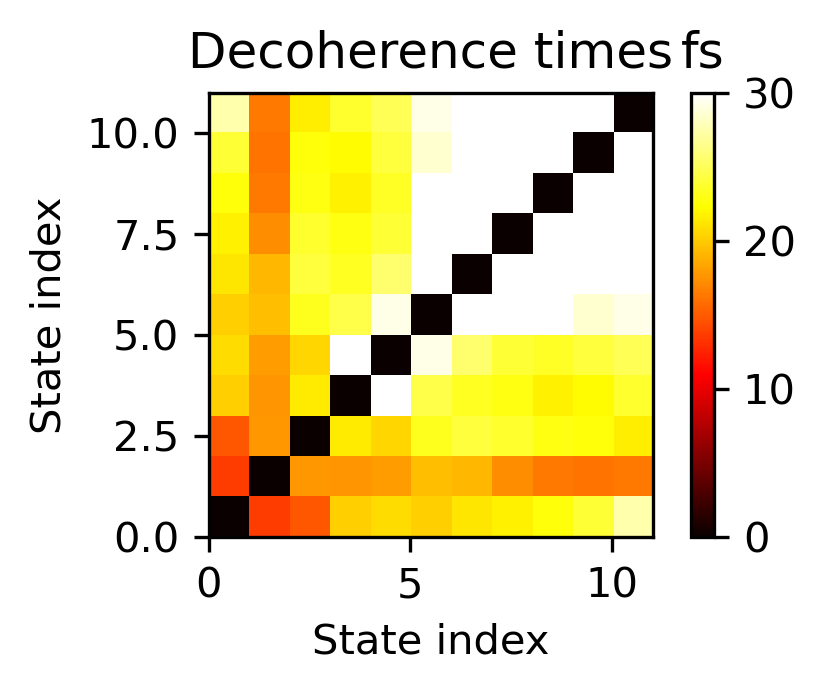

In [6]:
#%matplotlib notebook
%matplotlib inline 
plt.figure(num=None, figsize=(3.21*1, 2.41), dpi=300, edgecolor='black', frameon=True)

#plt.figure()
avg_deco = np.loadtxt('decoherence_times.txt')
nstates = avg_deco.shape[0]
plt.imshow(np.flipud(avg_deco), cmap='hot', extent=(0,nstates,0,nstates))#, vmin=0, vmax=100)
plt.xlabel('State index')
plt.ylabel('State index')
colorbar = plt.colorbar()
colorbar.ax.set_title('fs')
plt.clim(vmin=0, vmax=30)
plt.title(F'Decoherence times')
plt.tight_layout()
plt.savefig('Decoherence_times.png')
plt.show()

### 4.2. Nonadiabatic couplings map
<a name="4.2"></a>[Back to TOC](#TOC)

We can also plot the map of averaged NACs

In [7]:
# %matplotlib inline

# # Compute averaged NACs
# nac = np.zeros((NSTATES,NSTATES))
# files = glob.glob('/home/98722002/Desktop/WORK-DIRECTORY/ML-BP/3_nacs/PBE0/di_vacancy/res-mb-sd-DFT/Hvib*im*')
# for c, file in enumerate(files):
#     tmp = np.loadtxt(file)
#     nac += (np.abs(tmp)*1000*27.211385)
# nac /= c
# nstates = avg_deco.shape[0]

# plt.figure()
# plt.imshow(np.flipud(nac), cmap='hot', extent=(0,NSTATES,0,NSTATES))#, vmin=0, vmax=100)
# plt.xlabel('State index')
# plt.ylabel('State index')
# colorbar = plt.colorbar()
# colorbar.ax.set_title('meV')
# plt.clim(vmin=0, vmax=40)
# plt.title(F'Nonadiabatic couplings')
# plt.tight_layout()
# plt.savefig('Nonadiabatic_couplings.png', dpi=600)

## 5. Dynamics
<a name="5"></a>[Back to TOC](#TOC)

### 5.1. Setting up simulation parameters
<a name="5.1"></a>[Back to TOC](#TOC)

`model_params` should be initialized the way shown - some of the keywords are required; if omitted, the calculations may crash expectedly; Not much to discuss here. 

`dyn_general` - these are the parameters controlling the dynamics. A few special points of attention:

   - `NSTEPS` - as you can see, this number is chosen to be larger than the actual number of files read. Such calculations are allowed and would utilize the looping of the initial data. The looping will be done with the time-period controlled by the `nfiles` (998) parameter here. Basically, when the local "timestep" is larger than `nfiles`, the division remainder will be used to determine the index of the actual data to be used in such calculations. Note, the "timestep" takes into account the `icond` key of the `model_params` dictionary. That is if we have started with `icond == 301` and try doing `NSTEPS == 2000`, the index of the data used to compute step  1499 would be  301 + 1499 mod 998 = 802

   - `dt` - should be the same value as used in the nuclear dynamics (to produce time-overlaps and couplings), in a.u. of time
   
   - `rates` - are computed in the analysis above; these matrices are needed for some decoherence-corrected methods: DISH_rev2023 and MSDM, but not for others. If you want to do just do FSSH or IDA, you don't need it;
   
   - `gaps` - only needed if you plan on doing the `dephasing_informed == 1` option; if not - it is not needed;
   
   - `prefix` and `prefix2` - are needed; even though they are updated later on, it is important to have them here as well, or you may get some crashes; 
   
   - `mem_output_level` and `properties_to_save` - define a really minimalistic set of observables to compute/fook for, but it helps saving some disk space and speed up the calculations (overcoming the read/write bottleneck)
   

To select the method of choice, simply uncomment one of the lines that look like:

    mash_nbra.load(dyn_general); prf = "MASH"  # MASH
    
and, of course, comment the other methods.

What this instruction does it overrides the key-value pairs defined in `dyn_general` (or defines them, if they are not yet defined), according to the method of choice.

`nucl_params` - do not really matter for the NBRA calculations, so keep them as they are

`elec_params` - electronic parameters; mainly not much to choose here except for defining the state of interes (the one with index 3 in this example, that is this is 3-rd excited state). Note that the initialization of electronic variables in MASH is different from that in all other methods, but this is taken care of by the current script.

In [8]:
#================== Model parameters ====================
model_params = { "timestep":0, "icond":0,  "model0":0, "nstates":NSTATES }

#=============== Some automatic variables, related to the settings above ===================
#############
nsteps = NSTATES
#############

dyn_general = { "nsteps":5*NSTEPS, "ntraj":1998, "nstates":NSTATES, "dt":1.0*units.fs2au,
                "decoherence_rates":rates, "ave_gaps":gaps,                
                "progress_frequency":0.1, "which_adi_states":range(NSTATES), "which_dia_states":range(NSTATES),
                "mem_output_level":2,
                "properties_to_save":[ "timestep", "time","se_pop_adi", "sh_pop_adi" ],
                "prefix":F"NBRA", "prefix2":F"NBRA", "isNBRA":0, "nfiles": nsteps - 1
              }
##########################################################

#============== Select the method =====================
#dish_rev2023_nbra.load(dyn_general); prf = "DISH_rev2023"  # DISH_rev2023
#dish_rev2023_gfsh_nbra.load(dyn_general); prf = "DISH_rev2023_GFSH"  # DISH_rev2023_GFSH
#ida_gfssh_nbra.load(dyn_general); prf = "IDA_GFSSH"  # IDA_GFSSH
#msdm_gfsh_nbra.load(dyn_general); prf = "MSDM_GFSH"  # MSDM_GFSH
#ida_nbra.load(dyn_general); prf = "IDA"  # IDA
msdm_nbra.load(dyn_general); prf = "MSDM"  # MSDM
##########################################################

#=================== Initial conditions =======================
#============== Nuclear DOF: these parameters don't matter much in the NBRA calculations ===============
nucl_params = {"ndof":1, "init_type":3, "q":[-10.0], "p":[0.0], "mass":[2000.0], "force_constant":[0.01], "verbosity":-1 }

#============== Electronic DOF: Amplitudes are sampled ========
elec_params = {"ndia":NSTATES, "nadi":NSTATES, "verbosity":-1, "init_dm_type":0}

###########
istate = 1
###########
elec_params.update( {"init_type":1,  "rep":1,  "istate":istate } )  # how to initialize: random phase, adiabatic representation

if prf=="MASH":
    istates = list(np.zeros(NSTATES))
    istates[istate] = 1.0
    elec_params.update( {"init_type":4,  "rep":1,  "istate":3, "istates":istates } )  # different initialization for MASH

### 5.2. Running the dynamics
<a name="5.2"></a>[Back to TOC](#TOC)

To run the dynamics using multithreading, we create a single-parameter function that sets up the parameters, creates separate random numbers generator object and executed the calculations. This function `function1` is later passed to the `pool.map` function, which spawns several instances of the calculations. 

As our practice shows, one has to be really carefull how to setup the random number generators. If one uses a common random generator object, each instance of the spawned `function1` function will use almost the same sequence of the pseudo-random generated numbers. The reason if because all `Random` objects would be created nearly at the same time by the `pool.map`. As such, their random number initialization would be happening at nearly the same time. Since the system time is the most commonly-used way to pick the seed for the sequence of pseudorandom numbers and since such times would be very close for all thereads, one would basically run NA-MD calculations with nearly the same pseudorandom number sequences. The sampling would be poor. One could basically do just a single sequence of stochastic process of surface hopping. 

To initialize the seeds for each process, we use the `time.sleep` function with the wait time proportional to the initial condition index. In this way, the random number generators used by each thread would be sufficiently distinct and would produce different stochastic hopping trajectories. 

In [9]:
def function1(icond):
    print('Running the calculations for icond:', icond)
    time.sleep( icond * 0.01 )
    rnd=Random()
    mdl = dict(model_params)
    mdl.update({"icond": icond})  #create separate copy
    dyn_gen = dict(dyn_general)
    dyn_gen.update({"prefix":F"{prf}_icond_{icond}", "prefix2":F"{prf}_icond_{icond}" })
    res = tsh_dynamics.generic_recipe(dyn_gen, compute_model, mdl, elec_params, nucl_params, rnd)

Here, we finally start the calculations themselves.

We use 4 threads and 4 initial conditions (starting at files 1, 301, 601, and 901).

In [10]:
# ################################
nthreads =32
ICONDS = list(range(1,1000,20))
################################

# pool = mp.Pool(nthreads)
# pool.map(function1, ICONDS)
# pool.close()                            
# pool.join()

### 5.3. Visualizing the results of the dynamics and fitting the curves
<a name="5.3"></a>[Back to TOC](#TOC)

First define a fitting function - usually this is an exponential decay function:

In [11]:
def exp_funct(t, _x):
    return 1-np.exp(-np.power(t/_x, 1))

In [12]:
def Gau_funct(t, _x):
    return 1-np.exp(-np.power(t/_x, 2))

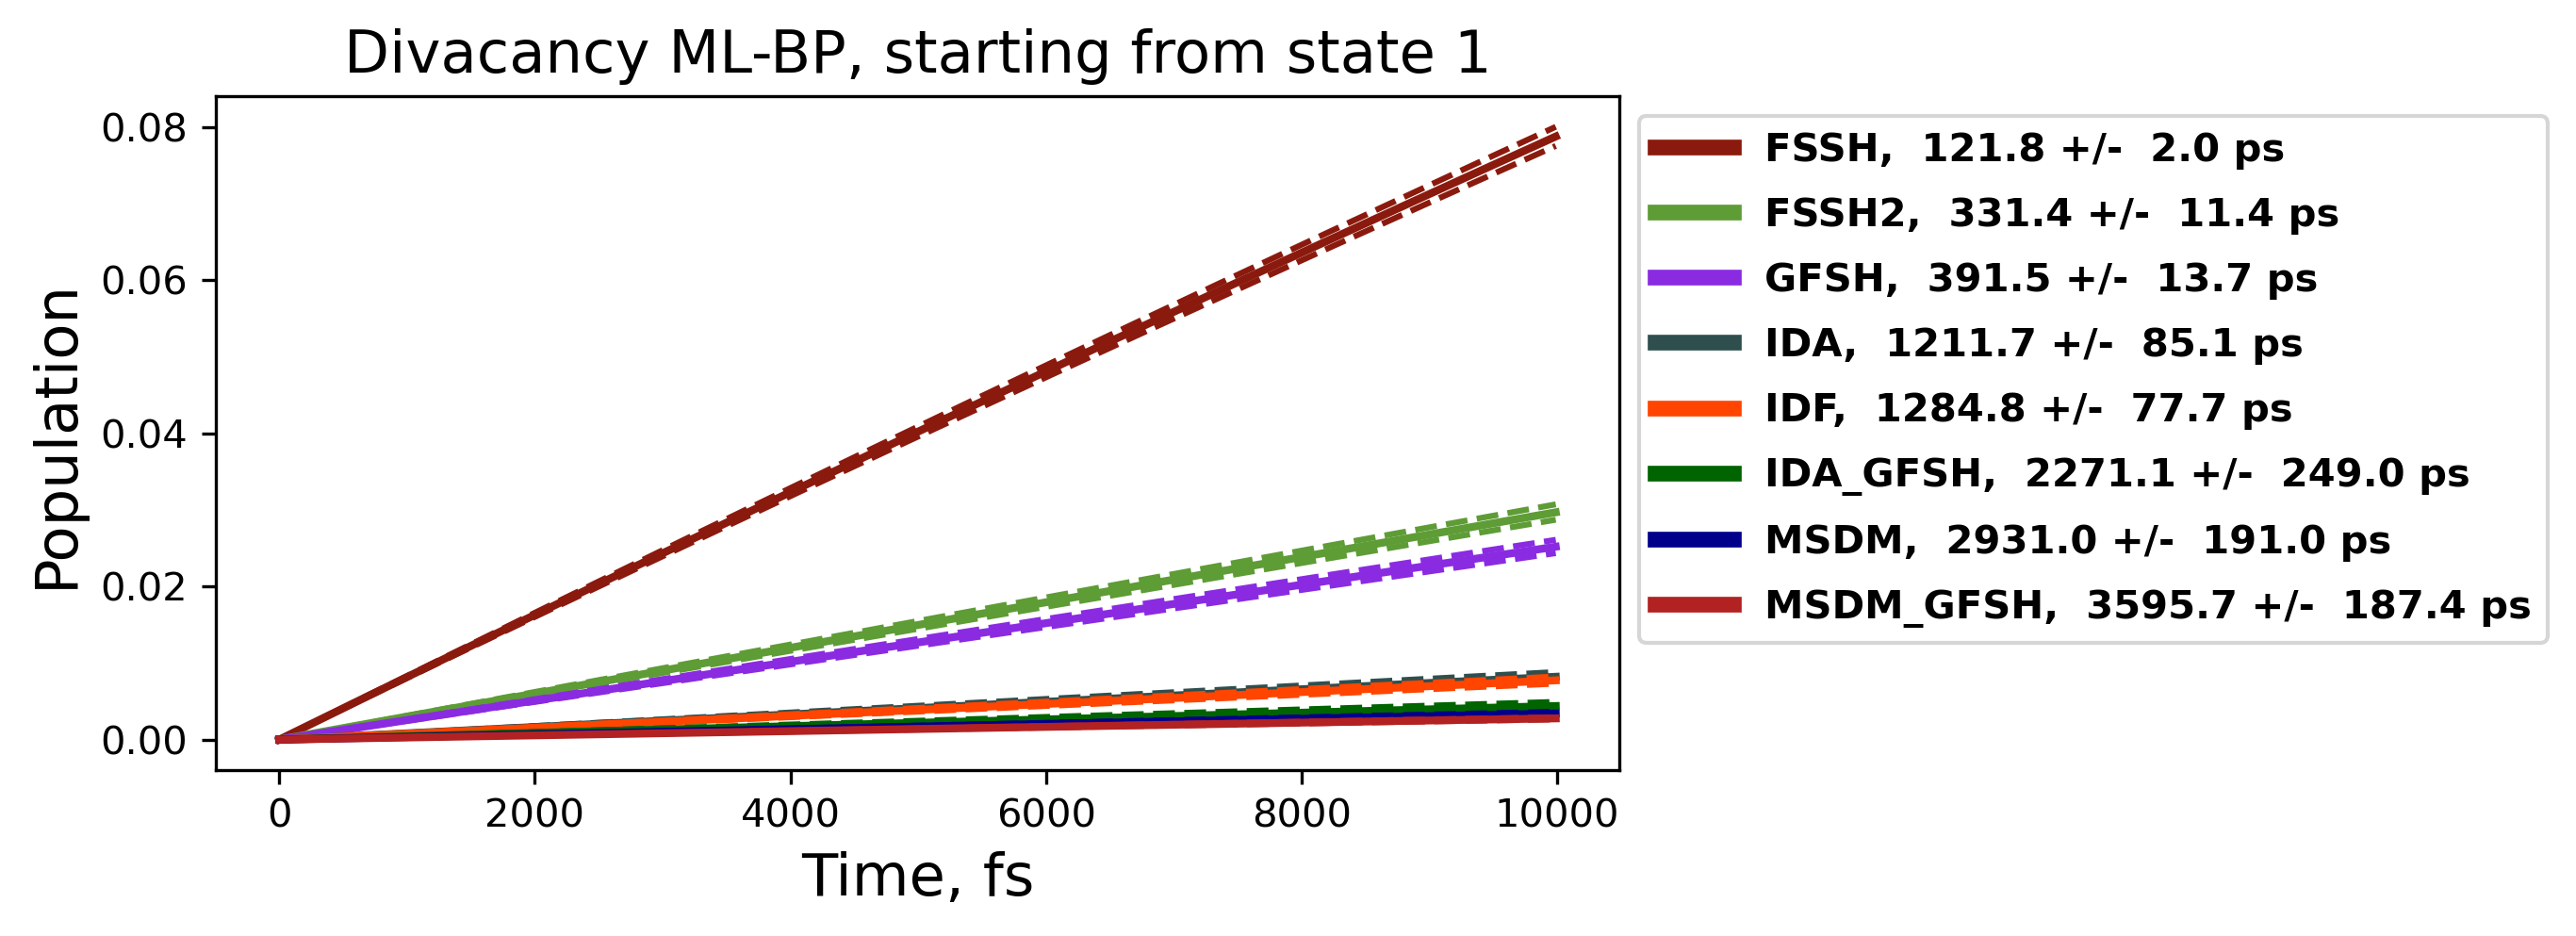

In [13]:
%matplotlib inline
plt.figure(num=None, figsize=(9.21*1, 3.41), dpi=300, edgecolor='black', frameon=True)

for c, method in enumerate(['FSSH','FSSH2','GFSH',  'IDA','IDF','IDA_GFSH' ,'MSDM','MSDM_GFSH']):#,
    taus = []
    #plt.figure(num=None, figsize=(7.21*1, 4.41), dpi=300, edgecolor='black', frameon=True)

    for icond in ICONDS:
        #print( F'{method}_icond_{icond}/mem_data.hdf' )
        F = h5py.File(F'{method}_icond_{icond}/mem_data.hdf')
        sh_pop = np.array(F['sh_pop_adi/data'][:,0])#istate])
        se_pop = np.array(F['se_pop_adi/data'][:,0])#istate])
        POP = sh_pop
        md_time = np.array(F['time/data'][:]) * units.au2fs
        #plt.plot(md_time, POP, color='gray')
        F.close()
        funct = exp_funct
        if method=="FSHH":
            funct = Gau_funct
        else:
            funct = exp_funct
        popt, pcov = curve_fit( funct, md_time, POP, bounds=([0.0],[np.inf]))
        _tau = popt
        # Computing the R-squared
        residuals  = POP - funct(md_time, *popt)
        ss_res     = np.sum(residuals**2)
        ss_tot     = np.sum((POP - np.mean(POP))**2)
        r_squared  = 1.0 - (ss_res / ss_tot)
        #print(F"R2 = {r_squared}")
        if True:#r_squared>0.1:
            taus.append(_tau)
    plt.ylabel('Population',fontsize=15)
    plt.xlabel('Time, fs',fontsize=15)
    #plt.title(F'Method: {method}')
    
    taus = np.array(taus)    
    ave_tau = np.average(taus)
    s = np.std(taus)
    Z = 1.96
    N = taus.shape[0]
    error_bar = Z*s/np.sqrt(N)
    #print(F'The timescales for method {method}: {ave_tau}+-{error_bar} fs, averaged over {len(taus)} samples')
    clr = libra_py.data_visualize.colors[ libra_py.data_visualize.clrs_index[c]]
    plt.plot(md_time, funct(md_time, ave_tau-error_bar), ls='--', color=clr)
    plt.plot(md_time , funct(md_time, ave_tau), 
             label=F"{method}, {ave_tau/1000.0 : 3.1f} +/- {error_bar/1000.0 : 3.1f} ps", 
             linewidth=2 , color=clr)           
    #plt.plot(md_time, funct(md_time, ave_tau), ls='-',  color=clr, label=F"{method}")

    plt.plot(md_time, funct(md_time, ave_tau+error_bar), ls='--', color=clr)
    plt.title('Divacancy ML-BP, starting from state 1',fontsize=15)
    legend_properties = {'weight':'bold'}
    leg = plt.legend(prop=legend_properties, loc='upper left', bbox_to_anchor=(1, 1),fontsize=2,labelspacing = 0.7)#,labelspacing = 1)
    
    #plt.legend(fontsize=3, ncol=1, loc='upper left')
    #plt.legend(fontweight='bold')
    # set the linewidth of each legend object
    for legobj in leg.legendHandles:
        legobj.set_linewidth(4.0)

    plt.tight_layout()
    plt.savefig('dynamics-Divacancy-state1.png')
